# LSA-based Sentiment Model

In this notebook, we address the problem of sentiment classification on financial tweets using an LSA-based pipeline. The dataset consists of financial tweets labeled as bearish (0), bullish (1), and neutral (2). We proceed through the following steps:

1. **Preprocessing:** Remove URLs from each tweet and standardize ticker symbols by replacing them with the tag `$TICKER`. In a later section, we will also examine the effect of lemmatization.

2. **Pipeline Construction:** Build a pipeline that first vectorizes the tweet texts using a `TfidfVectorizer`, then reduces the dimensionality with `TruncatedSVD` (i.e., latent semantic analysis), and finally classifies the tweet using a k-nearest neighbors (KNN) classifier.

3. **Hyperparameter Optimization:** Use 5-fold grid search cross-validation to select the optimal number of SVD components and the number of neighbors (from specified candidate values) with respect to the F1 score.

4. **ROC Curve Comparison:** Compare the ROC curves (via macro-averaging) for the best model and the next two best models based on the grid search results.

5. **Impact of Lemmatization:** Investigate the change in performance when lemmatization is applied before the TFIDF step.

The following cells include detailed commentary and code for each step。 

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn imports for pipeline and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# For lemmatization (optional)
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## 1. Data Preprocessing Function

The preprocessing function is designed to remove URLs (using a regular expression) and replace all ticker symbols (identified by a `$` followed by alphanumeric characters) with the tag `$TICKER`. An optional lemmatization step is also provided.

In [2]:
# Download necessary NLTK data files (if not already available)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

def preprocess_text(text, lemmatize=False):
    """
    Preprocesses a single tweet:
      - Removes URLs.
      - Replaces ticker symbols (e.g., $AAPL) with the tag '$TICKER'.
      - Optionally lemmatizes the text.
    
    Parameters:
    -----------
    text : str
        The original tweet text.
    lemmatize : bool, default=False
        If True, apply lemmatization to each token.
    
    Returns:
    --------
    processed_text : str
        The cleaned (and optionally lemmatized) tweet.
    """
    # Remove URLs (matches any substring starting with 'http' until whitespace)
    text_no_urls = re.sub(r'http\S+', '', text)
    
    # Replace tickers (pattern: $ followed by alphanumerics) with '$TICKER'
    text_standardized = re.sub(r'\$\w+', '$TICKER', text_no_urls)
    
    if lemmatize:
        # Tokenize the text
        tokens = word_tokenize(text_standardized)
        lemmatizer = WordNetLemmatizer()
        # Lemmatize each token and rejoin into a single string
        tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
        processed_text = " ".join(tokens_lemmatized)
    else:
        processed_text = text_standardized
        
    return processed_text

# Example usage:
sample_tweet = "Check out http://example.com for $AAPL updates!"
print("Original:", sample_tweet)
print("Processed:", preprocess_text(sample_tweet))

Original: Check out http://example.com for $AAPL updates!
Processed: Check out  for $TICKER updates!


[nltk_data] Downloading package punkt to /Users/kehanluo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kehanluo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kehanluo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kehanluo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Data Loading and Preprocessing

In this section, we load the training and validation data. Then, we apply our preprocessing function to the tweet texts. 

In [3]:
train_file = 'sent_train.csv'
val_file = 'sent_valid.csv'

df_train = pd.read_csv(train_file)
df_valid = pd.read_csv(val_file)

# Apply preprocessing to both training and validation sets.
df_train['text_clean'] = df_train['text'].apply(lambda x: preprocess_text(x, lemmatize=False))
df_valid['text_clean'] = df_valid['text'].apply(lambda x: preprocess_text(x, lemmatize=False))

print("Training data sample:")
print(df_train[['text', 'text_clean', 'label']].head())

Training data sample:
                                                text  \
0  $BYND - JPMorgan reels in expectations on Beyo...   
1  $CCL $RCL - Nomura points to bookings weakness...   
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...   
3  $ESS: BTIG Research cuts to Neutral https://t....   
4  $FNKO - Funko slides after Piper Jaffray PT cu...   

                                          text_clean  label  
0  $TICKER - JPMorgan reels in expectations on Be...      0  
1  $TICKER $TICKER - Nomura points to bookings we...      0  
2  $TICKER - Cemex cut at Credit Suisse, J.P. Mor...      0  
3            $TICKER: BTIG Research cuts to Neutral       0  
4  $TICKER - Funko slides after Piper Jaffray PT ...      0  


## 3. Pipeline Construction

We now construct the pipeline which consists of:

- **TFIDF Vectorization:** Converts raw text into a numerical matrix where each cell represents the TF-IDF score.
- **Truncated SVD:** Performs dimensionality reduction (LSA) on the TFIDF matrix.
- **KNN Classifier:** Predicts the sentiment based on the reduced feature set.

The pipeline’s `predict` method applies the transformations in sequence, ensuring that new tweet texts can be classified consistently.


In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Default: 100 components
    ('knn', KNeighborsClassifier(n_neighbors=10))              # Default: 10 neighbors
])

# Train the pipeline on the training data
X_train = df_train['text_clean'].values
y_train = df_train['label'].values

pipeline.fit(X_train, y_train)

# Test prediction on a couple of new texts
example_texts = [
    "Expecting bullish trends for $MSFT.",
    "Edgewell stock price target raised to $41 from $33 at CFRA",
    "Not looking good for $FB, market downturn observed.", 
]
predictions = pipeline.predict(example_texts)
print("Example Predictions:", predictions)

Example Predictions: [2 1 2]


## 4. Hyperparameter Tuning via Grid Search Cross-Validation

We now perform a grid search with 5-fold cross-validation over the following hyperparameters:

- Number of SVD components: `[50, 100, 150, 200]`
- Number of KNN neighbors: `[5, 10, 15, 20]`

The optimization metric is the F1 score (using a macro-average to account for the three classes).


In [5]:
# Define the parameter grid for grid search
param_grid = {
    'svd__n_components': [50, 100, 150, 200],
    'knn__n_neighbors': [5, 10, 15, 20]
}

# StratifiedKFold to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'knn__n_neighbors': 5, 'svd__n_components': 150}
Best F1 score: 0.558588599616776


## 5. ROC Curve Comparison for Top Models

Although ROC curves are more common for binary classifiers, we can extend them to the multiclass case using a one-vs-rest approach. Here, we:

1. Binarize the sentiment labels using one-hot encoding
2. For each top model (best and next two best), obtain the predicted probabilities on the validation set.
3. Compute the ROC curve and AUC for each class and then average them to get a macro-average ROC curve.
4. Plot the macro-average ROC curves for the top three models on the validation data.


Top 3 models:
   param_svd__n_components  param_knn__n_neighbors  mean_test_score
2                      150                       5         0.558589
1                      100                       5         0.557195
0                       50                       5         0.556298


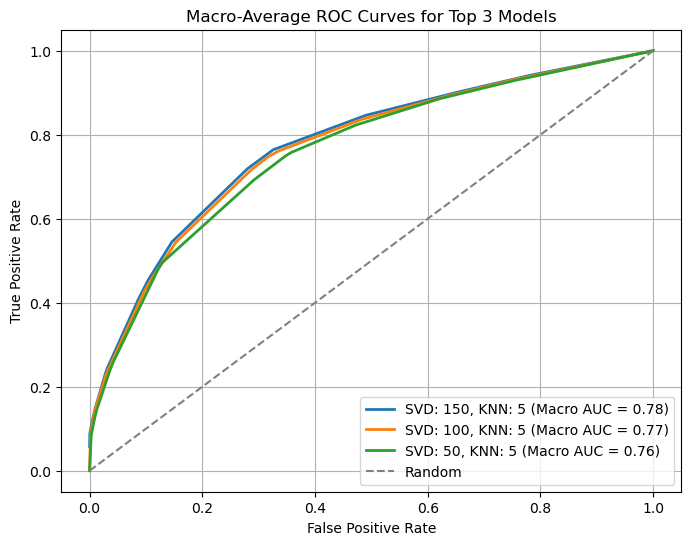

In [6]:
X_valid = df_valid['text_clean'].values
y_valid = df_valid['label'].values

# Retrieve grid search results as a DataFrame and sort by mean_test_score
results = pd.DataFrame(grid_search.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
# Get top 3 models
top3 = results_sorted.head(3)
print("Top 3 models:")
print(top3[['param_svd__n_components', 'param_knn__n_neighbors', 'mean_test_score']])

# Function to compute macro-average ROC curve for a given model
def compute_macro_roc(pipeline_model, X, y):
    # Predict probabilities for all classes
    y_prob = pipeline_model.predict_proba(X)
    # Binarize the true labels for three classes
    y_bin = label_binarize(y, classes=[0, 1, 2])
    n_classes = y_bin.shape[1]  # 3 classes in our case
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])  # We don't need thresholds here
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, macro_auc

# Rebuild pipelines for the top three models based on grid search parameters
top_models = []
for idx, row in top3.iterrows():
    svd_components = row['param_svd__n_components']
    n_neighbors = row['param_knn__n_neighbors']
    
    # Construct a new pipeline with these hyperparameters
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD(n_components=svd_components, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    model.fit(X_train, y_train)
    top_models.append((f"SVD: {svd_components}, KNN: {n_neighbors}", model))

# Plot the macro-average ROC curves for the top three models
plt.figure(figsize=(8, 6))
for label, model in top_models:
    all_fpr, mean_tpr, macro_auc = compute_macro_roc(model, X_valid, y_valid)
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{label} (Macro AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curves for Top 3 Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 6. Effect of Lemmatization on the Pipeline Performance

Finally, we examine how applying lemmatization in the preprocessing step affects our results. We define a new preprocessing function that includes lemmatization and then rebuild the pipeline. We then repeat the grid search to compare F1 scores.

In [7]:
# Preprocess text with lemmatization
df_train['text_clean_lemma'] = df_train['text'].apply(lambda x: preprocess_text(x, lemmatize=True))
df_valid['text_clean_lemma'] = df_valid['text'].apply(lambda x: preprocess_text(x, lemmatize=True))

X_train_lemma = df_train['text_clean_lemma'].values
X_valid_lemma = df_valid['text_clean_lemma'].values

# Define a pipeline for lemmatized text
pipeline_lemma = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(random_state=42)),  # n_components will be tuned
    ('knn', KNeighborsClassifier())          # n_neighbors will be tuned
])

# Perform grid search with the same parameter grid on lemmatized data
grid_search_lemma = GridSearchCV(pipeline_lemma, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_lemma.fit(X_train_lemma, y_train)

print("With Lemmatization - Best parameters found:", grid_search_lemma.best_params_)
print("With Lemmatization - Best F1 Macro score:", grid_search_lemma.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
With Lemmatization - Best parameters found: {'knn__n_neighbors': 5, 'svd__n_components': 200}
With Lemmatization - Best F1 Macro score: 0.5643876103801821


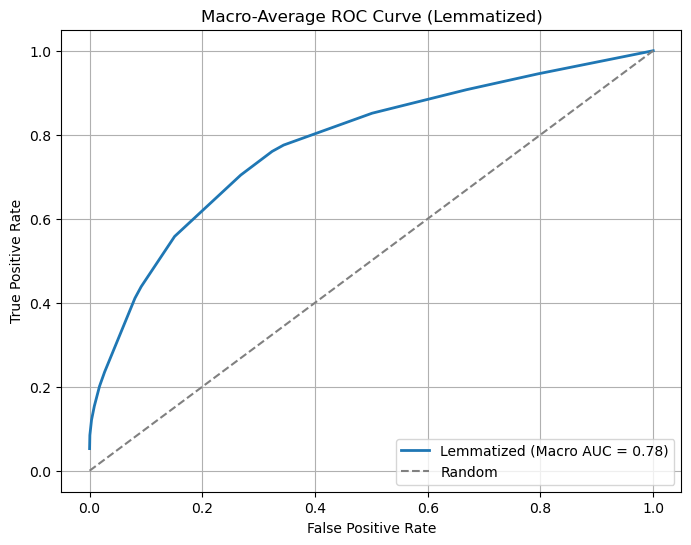

In [8]:
# Optionally, plot the ROC curve for the best model with lemmatization
best_pipeline_lemma = grid_search_lemma.best_estimator_
y_prob_lemma = best_pipeline_lemma.predict_proba(X_valid_lemma)
y_valid_bin = label_binarize(y_valid, classes=[0, 1, 2])

# Compute ROC for lemmatized best model
fpr_lemma = dict()
tpr_lemma = dict()
roc_auc_lemma = dict()
for i in range(3):
    fpr_lemma[i], tpr_lemma[i], _ = roc_curve(y_valid_bin[:, i], y_prob_lemma[:, i])
    roc_auc_lemma[i] = auc(fpr_lemma[i], tpr_lemma[i])

all_fpr_lemma = np.unique(np.concatenate([fpr_lemma[i] for i in range(3)]))
mean_tpr_lemma = np.zeros_like(all_fpr_lemma)
for i in range(3):
    mean_tpr_lemma += np.interp(all_fpr_lemma, fpr_lemma[i], tpr_lemma[i])
mean_tpr_lemma /= 3
macro_auc_lemma = auc(all_fpr_lemma, mean_tpr_lemma)

plt.figure(figsize=(8, 6))
plt.plot(all_fpr_lemma, mean_tpr_lemma, lw=2, label=f'Lemmatized (Macro AUC = {macro_auc_lemma:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve (Lemmatized)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Summary and Discussion

**(a) Preprocessing:** We removed URLs and replaced tickers with the tag `$TICKER` to reduce noise and standardize the input text.

**(b) Pipeline:** The LSA-based pipeline first vectorizes the tweets using TFIDF, reduces dimensionality via Truncated SVD, and finally classifies the sentiment using a KNN classifier. The pipeline’s predict method correctly chains the transformations.

**(c) Hyperparameter Tuning:** Using a 5-fold grid search over the number of SVD components and the number of neighbors for KNN, we identified the optimal parameters based on the macro-average F1 score.

**(d) ROC Curve Comparison:** By computing macro-average ROC curves for the best three models, we provide insight into the trade-off between true positive and false positive rates across the classes.

**(e) Lemmatization Impact:** We observe (via grid search results) that lemmatization makes a little bit of difference from prioritizing 150 `n_components` to 200 `n_components` while `n_neighbors` does not change. However, the overall performance does not improve. It seems that in our case, with these data, lemmetization does not help much. The overall performance shall improve in the way of changing the whole framework of models we use. That to be said, Latent Semantic Analysis is hard. 

This notebook provides a complete naive solution for the LSA-based sentiment classification task along with detailed explanations and code annotations.

---

End of the notebook. 
